In [83]:
#导入必要的包
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotnine import *
import seaborn as sns
import missingno as msno

# 1 导入数据

In [116]:
#读取数据
data = pd.read_csv('train.csv')

# 2 数据分析与数据清洗

## 2.1 异常值概览

In [117]:
#定义缺失值异常类
class NanError(Exception):
    
    def __init__(self,num,rate):
        self.num = num
        self.rate = rate

In [118]:
#寻找各列的缺失值，计算缺失率
for i in data.columns:
    try: 
        if data[[i]].isna().any()[0]:
            num = str(data[[i]].isna().sum()[0])
            rate = str(round(data[[i]].isna().sum()[0]/len(data[[i]]),4)*100)+'%'
            raise NanError(num,rate)
    
    except NanError as e:
        print('{}列存在'.format(i)+num+'个缺失值,缺失率为'+rate)

HomePlanet列存在201个缺失值,缺失率为2.31%
CryoSleep列存在217个缺失值,缺失率为2.5%
Cabin列存在199个缺失值,缺失率为2.29%
Destination列存在182个缺失值,缺失率为2.09%
Age列存在179个缺失值,缺失率为2.06%
VIP列存在203个缺失值,缺失率为2.34%
RoomService列存在181个缺失值,缺失率为2.08%
FoodCourt列存在183个缺失值,缺失率为2.11%
ShoppingMall列存在208个缺失值,缺失率为2.39%
Spa列存在183个缺失值,缺失率为2.11%
VRDeck列存在188个缺失值,缺失率为2.16%
Name列存在200个缺失值,缺失率为2.3%


## 2.2 逐变量分析和处理

### 2.2.1 消费变量

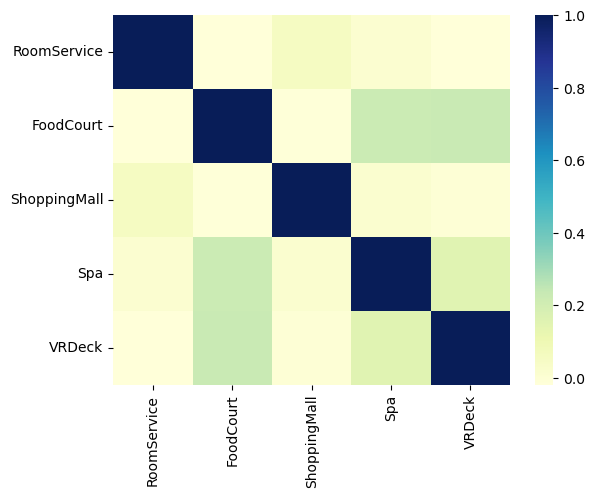

In [119]:
#绘制相关系数热力图
ax = sns.heatmap(data = data.loc[:,'RoomService':'VRDeck'].corr(),cmap='YlGnBu')

D:\ProgramData\Anaconda3\lib\site-packages\plotnine\layer.py:411: PlotnineWarning: geom_point : Removed 1073 rows containing missing values.


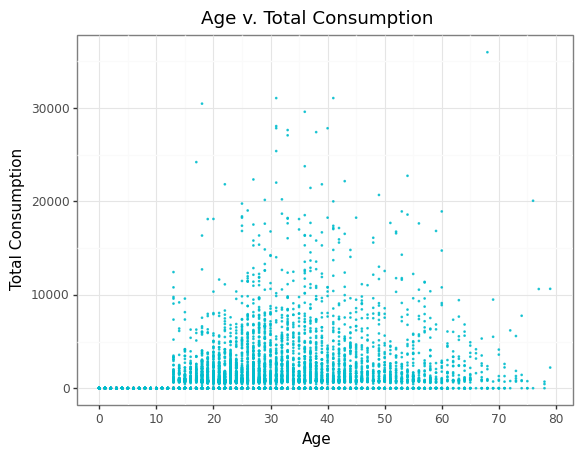

<ggplot: (93946076751)>

In [120]:
#绘图
data['Pay'] = data.loc[:,'RoomService':'VRDeck'].apply(sum,axis=1)
(ggplot()+
 geom_point(aes(x=data.Age,y=data.Pay),size=0.1,color = '#00bdcd',alpha = 0.8)+
 scale_x_continuous(breaks=np.linspace(0,80,9))+
 labs(title = 'Age v. Total Consumption',y='Total Consumption')+
 theme_bw()
)

In [121]:
data.groupby('CryoSleep').mean()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Pay
CryoSleep,,,,,,,,
False,29.651319,350.146772,713.004316,270.586504,486.09294,475.716165,0.328921,2304.194614
True,27.405415,0.000000,0.000000,0.000000,0.00000,0.000000,0.817583,0.000000


In [122]:
data.groupby(['VIP','HomePlanet']).mean().loc[:,'RoomService':'VRDeck']

RoomService    FoodCourt  ShoppingMall          Spa  \
VIP   HomePlanet                                                        
False Earth        137.112150   137.678889    134.621060   142.198906   
      Europa       131.645530  1422.728363    152.875851   839.451697   
      Mars         539.337654    49.199011    308.867820   105.456737   
True  Europa       280.558140  2631.500000    165.539062  1031.279070   
      Mars         844.360656   163.516667    431.098361   267.031746   

                       VRDeck  
VIP   HomePlanet               
False Earth        138.010509  
      Europa       809.780551  
      Mars          46.681312  
True  Europa      1833.279070  
      Mars          59.836066

In [123]:
#填补消费数据的缺失值
data.loc[data.Age<13,'RoomService':'VRDeck'] = data.loc[data.Age<13,'RoomService':'VRDeck'].fillna(0)
data.loc[data.CryoSleep==True,'RoomService':'VRDeck'] = data.loc[data.CryoSleep==True,'RoomService':'VRDeck'].fillna(0)
data.loc[data[['HomePlanet','VIP']].notna().all(1),'RoomService':'VRDeck']=data.groupby(['VIP','HomePlanet'])['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck'].apply(lambda x:x.fillna(x.mean()))
data.loc[:,'RoomService':'VRDeck'] = data.loc[:,'RoomService':'VRDeck'].fillna(data.mean(numeric_only=True))

C:\Users\M\AppData\Local\Temp\ipykernel_22592\3710108480.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


### 2.2.2 VIP

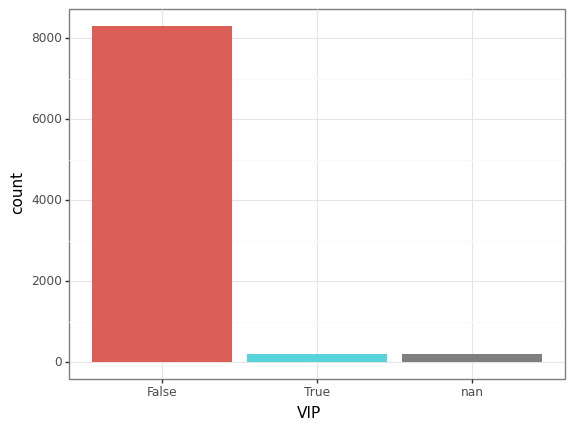

<ggplot: (93949205119)>

In [124]:
#VIP数据绘图
(ggplot()+
 geom_bar(aes(x=data.VIP,fill=data.VIP))+
 theme_bw()+
 theme(legend_position = 'none')
)

In [125]:
#填补VIP数据缺失值
data.loc[data.Pay<=10000,'VIP'] = data.loc[data.Pay<=10000,'VIP'].fillna('False')
data.loc[data.Pay>10000,'VIP'] = data.loc[data.Pay>10000,'VIP'].fillna('True')
data.VIP = data.VIP.astype(bool)

In [126]:
#分层填补
data.groupby(['VIP','HomePlanet']).mean()

Age  RoomService    FoodCourt  ShoppingMall  \
VIP   HomePlanet                                                      
False Earth       26.122644   135.934689   136.868463    132.920839   
      Europa      34.129184   130.559794  1404.422542    150.743802   
      Mars        29.029758   534.062958    48.539024    306.032436   
True  Earth       23.909910   130.681845   122.789961    104.872494   
      Europa      37.630058   297.896626  2376.191024    132.267547   
      Mars        33.485437   760.412465   136.259906    304.313177   

                         Spa       VRDeck  Transported          Pay  
VIP   HomePlanet                                                     
False Earth       141.393521   136.729742     0.424337   689.078849  
      Europa      829.917398   801.857878     0.670072  3376.181973  
      Mars        104.296455    46.167075     0.534180  1055.258086  
True  Earth       163.782609   141.591304     0.408696   664.490566  
      Europa      939.406625  1609.625300     0.531792  5524.050633  
      Mars        184.822393    59.251624     0.349057  1368.800000

D:\ProgramData\Anaconda3\lib\site-packages\plotnine\layer.py:333: PlotnineWarning: stat_bin : Removed 35 rows containing non-finite values.


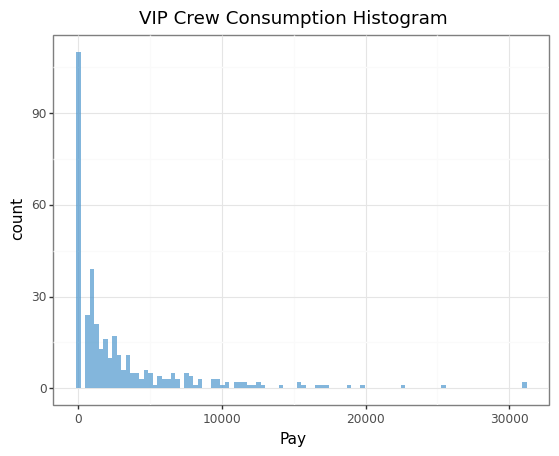

<ggplot: (93949412337)>

In [127]:
(ggplot(data=data.loc[data.VIP == True])+
geom_histogram(aes(x='Pay'),bins=100,fill='#4d97cd',alpha=0.7)+
theme_bw()+
labs(title='VIP Crew Consumption Histogram')
)

D:\ProgramData\Anaconda3\lib\site-packages\plotnine\layer.py:333: PlotnineWarning: stat_bin : Removed 873 rows containing non-finite values.


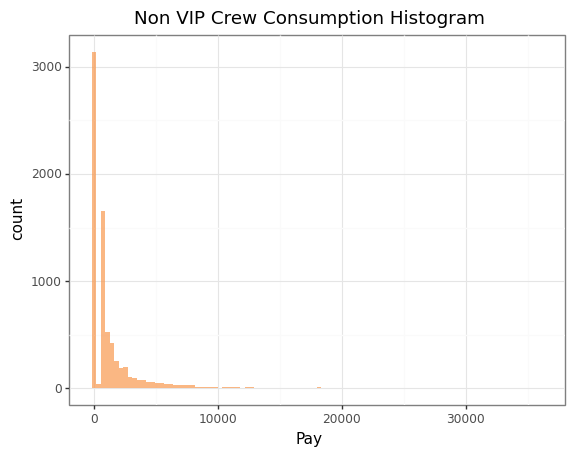

<ggplot: (93949523089)>

In [128]:
(ggplot(data=data.loc[data.VIP == False])+
geom_histogram(aes(x='Pay'),bins=100,fill='#f8984e',alpha=0.7)+
theme_bw()+
labs(title='Non VIP Crew Consumption Histogram')
)

D:\ProgramData\Anaconda3\lib\site-packages\plotnine\layer.py:333: PlotnineWarning: stat_boxplot : Removed 908 rows containing non-finite values.


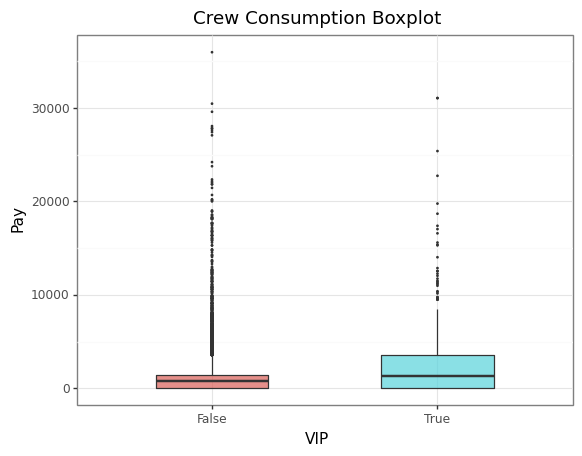

<ggplot: (93949527031)>

In [129]:
(ggplot()+
 geom_boxplot(aes(x=data.VIP,fill=data.VIP,y=data.Pay),outlier_size = 0.1,width=0.5,alpha=0.7)+
 theme_bw()+
 labs(title='Crew Consumption Boxplot')+
 theme(legend_position = 'none')
)

### 2.2.3 年龄

D:\ProgramData\Anaconda3\lib\site-packages\plotnine\layer.py:333: PlotnineWarning: stat_bin : Removed 179 rows containing non-finite values.


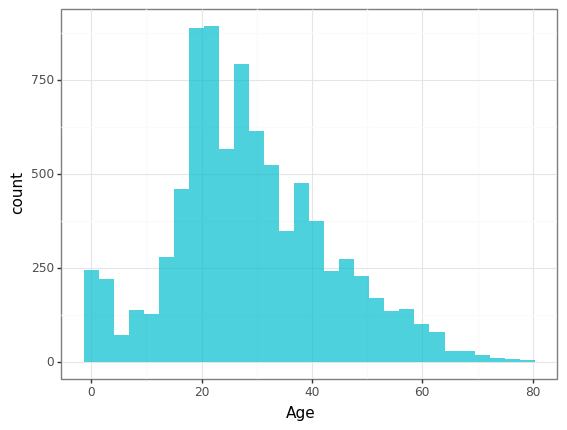

<ggplot: (93949712442)>

In [130]:
#分析年龄数据
(ggplot()+
geom_histogram(aes(x=data.Age),bins=30,fill='#00bdcd',alpha=0.7)+
theme_bw()
)

In [131]:
#填补年龄缺失值数据
data.loc[data[['HomePlanet']].notna().all(1),'Age']=data.groupby(['HomePlanet'])['Age'].apply(lambda x:x.fillna(x.mean()))
data.loc[:,'Age'].fillna(data.mean(numeric_only=True)['Age'],inplace= True)

### 2.2.4 来源、是否休眠和目的地

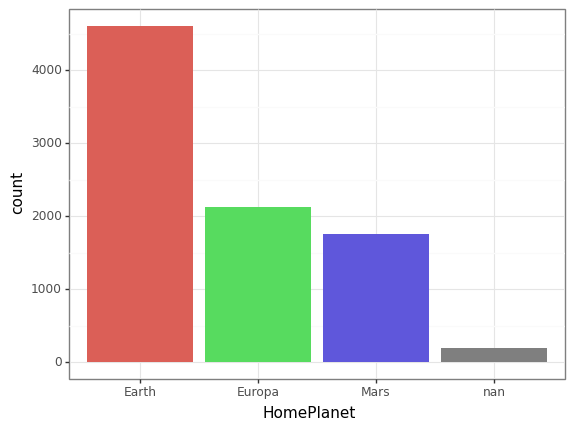

<ggplot: (93949747104)>

In [132]:
#来源地绘图
(ggplot()+
 geom_bar(aes(x=data.HomePlanet,fill=data.HomePlanet))+
 theme_bw()+
 theme(legend_position = 'none')
)

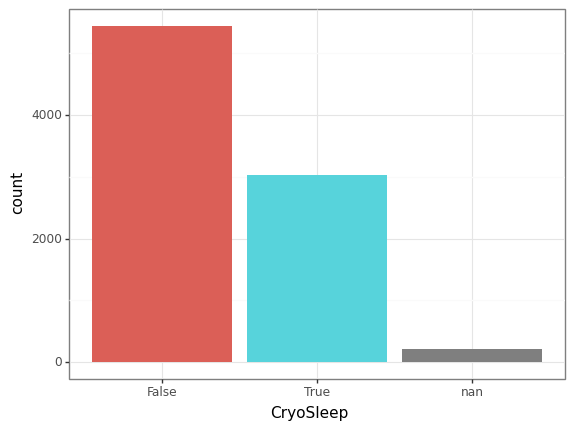

<ggplot: (93950948187)>

In [133]:
#是否休眠绘图
(ggplot()+
 geom_bar(aes(x=data.CryoSleep,fill=data.CryoSleep))+
 theme_bw()+
 theme(legend_position = 'none')
)

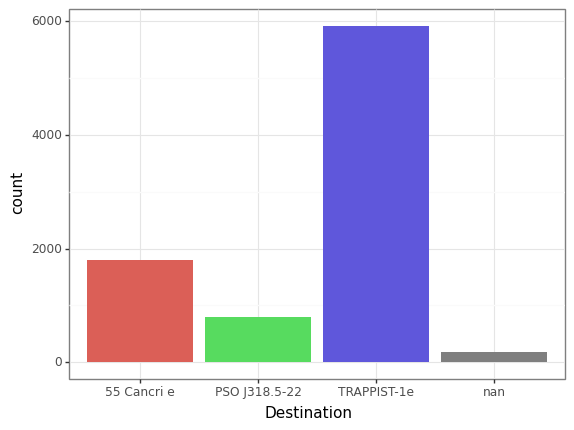

<ggplot: (93950960267)>

In [134]:
#目的地绘图
(ggplot()+
 geom_bar(aes(x=data.Destination,fill=data.Destination))+
 theme_bw()+
 theme(legend_position = 'none')
)

In [135]:
#众数填补以上三个变量
data.loc[:,'HomePlanet'] = data.loc[:,'HomePlanet'].fillna(data.HomePlanet.mode()[0])
data.loc[:,'CryoSleep'] = data.loc[:,'CryoSleep'].fillna(data.CryoSleep.mode()[0])
data.loc[:,'Destination'] = data.loc[:,'Destination'].fillna(data.Destination.mode()[0])

### 2.2.5 船舱

In [136]:
#拆分船舱变量并就近填补缺失值
data['Deck'] = data['Cabin'].str[0]
data['Num'] = data['Cabin'].str[2:-2]
data['Side'] = data['Cabin'].str[-1]
data.Deck.fillna(method='backfill',inplace = True)
data.Num.fillna(method='backfill',inplace = True)
data.Side.fillna(method='backfill',inplace = True)

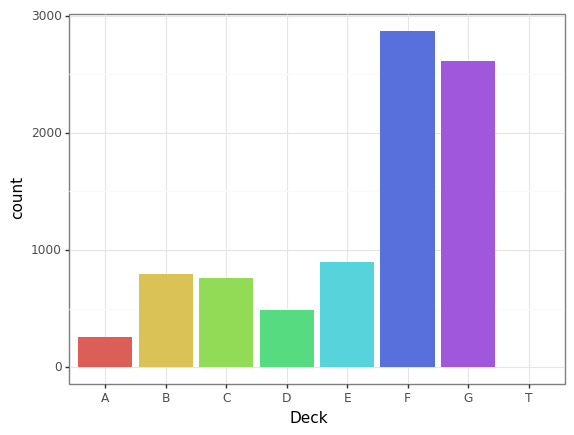

<ggplot: (93950990355)>

In [137]:
#甲板数据绘图
(ggplot()+
 geom_bar(aes(x=data['Deck'],fill=data['Deck']))+
 theme_bw()+
 theme(legend_position = 'none')
)

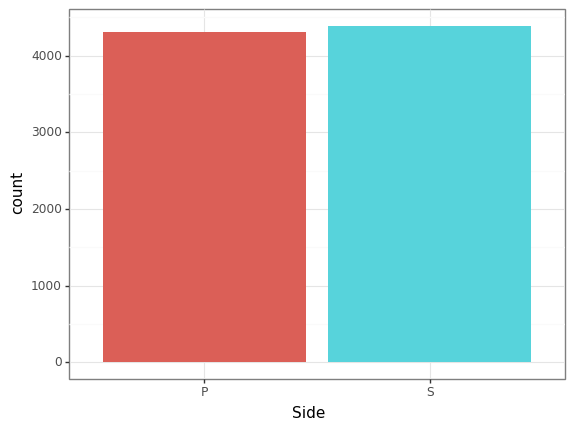

<ggplot: (93951073805)>

In [138]:
#舷侧数据绘图
(ggplot()+
 geom_bar(aes(x=data['Side'],fill=data['Side']))+
 theme_bw()+
 theme(legend_position = 'none')
)

## 2.3 数据编码

In [139]:
#数据类型转换
data.Num = data.Num.astype('float')
data.CryoSleep = data.CryoSleep.astype('int')
data.Transported = data.Transported.astype('int')
data.VIP = data.VIP.astype('int')

In [140]:
#数据one-hot编码
data = pd.concat([data,pd.get_dummies(data['HomePlanet'],prefix='HomePlanet',drop_first = True)],axis=1).drop('HomePlanet',axis=1)
data = pd.concat([data,pd.get_dummies(data['Destination'],prefix='Destination',drop_first = True)],axis=1).drop('Destination',axis=1)
data = pd.concat([data,pd.get_dummies(data['Deck'],prefix='Deck',drop_first = True)],axis=1).drop('Deck',axis=1)
data = pd.concat([data,pd.get_dummies(data['Side'],prefix='Side',drop_first = True)],axis=1).drop('Side',axis=1)

In [141]:
new_data = data.drop(columns = ['PassengerId','Pay','Name','Cabin'])

# 3 模型构建

In [145]:
#导入机器学习包
import sklearn
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import KFold, cross_validate, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn import svm
from sklearn.preprocessing import scale
import statsmodels.api as sm

In [150]:
#分割样本x和y
y = new_data.Transported
x = new_data.drop(columns=['Transported'])

## 3.1 逻辑回归

In [149]:
#statsmodels包里的逻辑回归
model = sm.Logit(y,sm.add_constant(x))
res = model.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.430855
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            Transported   No. Observations:                 8693
Model:                          Logit   Df Residuals:                     8671
Method:                           MLE   Df Model:                           21
Date:                Sat, 14 Jan 2023   Pseudo R-squ.:                  0.3784
Time:                        18:48:32   Log-Likelihood:                -3745.4
converged:                       True   LL-Null:                       -6025.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -0.4856      0.295     -1.644      0.100      -1.065       0.093
CryoSleep                     1.3307      0.079     16.829      0.000       1.176       1.486
Age                          -0.0089      0.002     -4.297      0.000      -0.013      -0.005
VIP                          -0.0504      0.151     -0.333      0.739      -0.347       0.246
RoomService                  -0.0015   9.26e-05    -16.663      0.000      -0.002      -0.001
FoodCourt                     0.0005    4.1e-05     12.561      0.000       0.000       0.001
ShoppingMall                  0.0005   6.63e-05      7.715      0.000       0.000       0.001
Spa                          -0.0021      0.000    -19.531      0.000      -0.002      -0.002
VRDeck                       -0.0020      0.000    -18.854      0.000      -0.002      -0.002
Num                           0.0002   6.58e-05      3.167      0.002    7.95e-05       0.000
HomePlanet_Europa             1.5937      0.211      7.541      0.000       1.180       2.008
HomePlanet_Mars               0.5480      0.092      5.949      0.000       0.367       0.728
Destination_PSO J318.5-22    -0.4264      0.112     -3.807      0.000      -0.646      -0.207
Destination_TRAPPIST-1e      -0.4443      0.081     -5.504      0.000      -0.603      -0.286
Deck_B                        1.2888      0.259      4.970      0.000       0.781       1.797
Deck_C                        2.4751      0.289      8.566      0.000       1.909       3.041
Deck_D                        0.6829      0.281      2.428      0.015       0.132       1.234
Deck_E                        0.1373      0.281      0.489      0.625      -0.413       0.688
Deck_F                        0.5985      0.288      2.080      0.038       0.035       1.162
Deck_G                        0.2037      0.292      0.697      0.486      -0.369       0.776
Deck_T                       -0.4744      1.749     -0.271      0.786      -3.902       2.953
Side_S                        0.5882      0.058     10.217      0.000       0.475       0.701
=============================================================================================
"""

In [ ]:
#剔除部分参数后的逻辑回归样例，其他情况省略
model = sm.Logit(y,sm.add_constant(x.iloc[:,np.r_[0,1,3:8,9:12]]))
res = model.fit()
res.summary()

In [152]:
#sklearn包里的逻辑回归，进行交叉验证
cv = KFold(n_splits=5,shuffle=True,random_state=1)
LR = LogisticRegression(penalty="l2", C=1.0, random_state=None, solver="lbfgs", max_iter=100000,multi_class='ovr', verbose=0,)
score_LR = cross_validate(LR, x.iloc[:,np.r_[0,1,3:8,9:12]], y, return_train_score=True, scoring='accuracy',cv=cv)
score_LR['test_score'].mean()

0.7877593236063476

## 3.2 随机森林

In [154]:
#随机森林
RF = RandomForestClassifier(n_estimators=120,max_depth=13,random_state=1,min_samples_leaf=4,min_samples_split=9)
score_RF = cross_validate(RF,x,y,return_train_score=True, scoring='accuracy',cv=cv,n_jobs=12)
score_RF['test_score'].mean()

0.8062802120976105

In [1234]:
#绘制随机森林系数重要性和逻辑回归z值的相关图
plt.scatter(x=RF.feature_importances_,
            y=[16.829,4.297,0.333,16.663,12.561,7.715,19.531,18.854,3.167,10.217,7.541,
               5.949,3.807,5.504,4.970,8.566,2.428,0.489,2.080,0.697,0.271],s=8,color='#00bdcd')
plt.xlabel('feature_importance')
plt.ylabel('abs of z')

array([0.13747317, 0.05614689, 0.00208449, 0.12355172, 0.09265816,
       0.07975779, 0.15282584, 0.12537202, 0.07102556, 0.01999371,
       0.03176666, 0.01873775, 0.00423598, 0.00968959, 0.01009294,
       0.0106326 , 0.00282849, 0.01232149, 0.01640037, 0.02240478,
       0.        ])

In [ ]:
#计算相关系数
cor = pd.DataFrame(RF.feature_importances_)
cor['1'] = [16.829,4.297,0.333,16.663,12.561,7.715,19.531,18.854,3.167,10.217,7.541,
               5.949,3.807,5.504,4.970,8.566,2.428,0.489,2.080,0.697,0.271]
cor.corr()

### 3.2.1 n_estimators

In [155]:
#获取n_estimators数据
score_n_train = []
score_n_test = []

for i in range(0,305,5):
    RF = RandomForestClassifier(n_estimators=i+1,random_state=1)
    score = cross_validate(RF,x,y,return_train_score=True, scoring='accuracy',cv=cv,n_jobs=12)
    sample_test = score['test_score'].mean()
    sample_train = score['train_score'].mean()
    score_n_train.append(sample_train)
    score_n_test.append(sample_test)

Text(0, 0.5, 'accuracy')

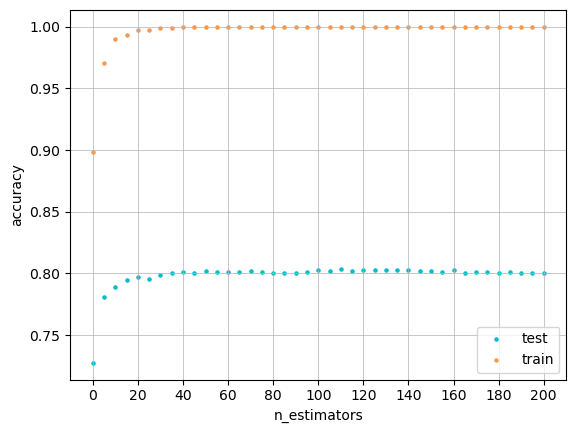

In [157]:
#绘图
n_estimators = []
for i in range(0,305,5):
    n_estimators.append(i)

plt.scatter(x=n_estimators[0:41],y=score_n_test[0:41],s = 5,color = '#00bdcd',label='test')
plt.scatter(x=n_estimators[0:41],y=score_n_train[0:41],s = 5,color = '#f8984e',label='train')
plt.grid(linewidth=0.5)
plt.xticks(np.linspace(0,200,11))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('accuracy')

### 3.2.1 max_depth

In [158]:
#获取max_depth数据
score_md_train = []
score_md_test = []

for i in range(1,20):
    RF = RandomForestClassifier(n_estimators=80,random_state=1,max_depth=i)
    score = cross_validate(RF,x,y,return_train_score=True, scoring='accuracy',cv=cv,n_jobs=12)
    sample_train = score['train_score'].mean()
    sample_test = score['test_score'].mean()
    score_md_train.append(sample_train)
    score_md_test.append(sample_test)

Text(0, 0.5, 'accuracy')

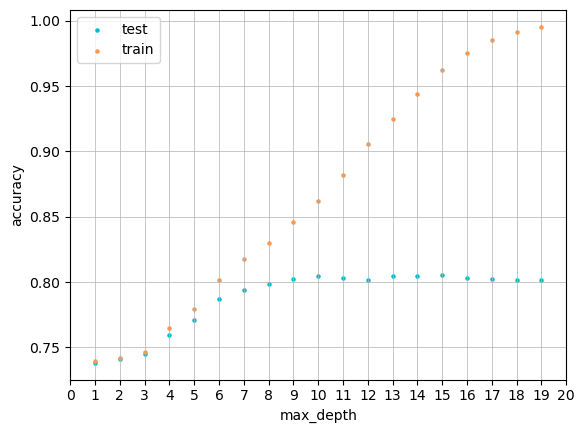

In [159]:
max_depth = []
for i in range(1,20):
    max_depth.append(i)

plt.scatter(x=max_depth,y=score_md_test,s = 5,color = '#00bdcd',label='test')
plt.scatter(x=max_depth,y=score_md_train,s = 5,color = '#f8984e',label='train')
plt.grid(linewidth=0.5)
plt.xticks(np.linspace(0,20,21))
plt.legend()
plt.xlabel('max_depth')
plt.ylabel('accuracy')

### 3.2.3 其他参数

In [1047]:
#网格搜索进行其他参数的调参
param = {'min_samples_leaf':range(1,10,1), 'min_samples_split':range(1,10,1)}
gsearch1 = GridSearchCV(estimator = RandomForestClassifier(n_estimators=120,max_depth=13,
                                  max_features='sqrt',random_state=1,n_jobs=14), 
                       param_grid = param, scoring='accuracy',cv=cv)
gsearch1.fit(x,y)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
45 fits failed out of a total of 405.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "D:\ProgramData\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 436, in _process_worker
    r = call_item()
  File "D:\ProgramData\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 288, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "D:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 595, in __call__
    re

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=RandomForestClassifier(max_depth=13, n_estimators=120,
                                              n_jobs=14, random_state=1),
             param_grid={'min_samples_leaf': range(1, 10),
                         'min_samples_split': range(1, 10)},
             scoring='accuracy')

In [1048]:
gsearch1.best_params_

{'min_samples_leaf': 4, 'min_samples_split': 9}

## 3.3支持向量机

In [1101]:
#建模支持向量机
SVM = svm.SVC(gamma=0.001, C=1000, decision_function_shape='ovr', kernel='rbf')
score_SVM = cross_validate(SVM,scale(x),y,return_train_score=True, scoring='accuracy',cv=cv,n_jobs=12)

In [1103]:
score_SVM['train_score'].mean()

0.8138443054047062

In [1102]:
score_SVM['test_score'].mean()

0.8042095936251605

In [1095]:
#网格搜索调参
param = {'C':[1e-3, 1e-2, 1e-1, 1, 10, 100, 1000], 'gamma': [0.001, 0.0001,0.01]}
gsearch2 = GridSearchCV(estimator = svm.SVC(decision_function_shape='ovr', kernel='rbf'), 
                       param_grid = param, scoring='accuracy',cv=cv)
gsearch2.fit(scale(x),y)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'gamma': [0.001, 0.0001, 0.01]},
             scoring='accuracy')

In [1096]:
gsearch2.best_params_

{'C': 1000, 'gamma': 0.001}

## 3.4 Adaboosting

In [165]:
#建模决策树和AdaBoost
DT = DecisionTreeClassifier(max_depth = 12,splitter='best',min_samples_leaf=41,min_samples_split=8)
boostmodel = AdaBoostClassifier(DT,random_state=1,n_estimators=40,learning_rate=0.057)
score_Ada = cross_validate(boostmodel, x, y, return_train_score=True, scoring='accuracy',cv=cv)
score_DT = cross_validate(DT, x, y, return_train_score=True, scoring='accuracy',cv=cv)

In [160]:
#网格搜索调参决策树
param = {'max_depth':range(10,22,1), 'min_samples_split': range(2,20,2),'min_samples_leaf':range(1,51,10)}
gsearch3 = GridSearchCV(estimator = DecisionTreeClassifier(), 
                       param_grid = param, scoring='accuracy',cv=cv)
gsearch3.fit(x,y)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(10, 22),
                         'min_samples_leaf': range(1, 51, 10),
                         'min_samples_split': range(2, 20, 2)},
             scoring='accuracy')

In [162]:
gsearch3.best_params_

{'max_depth': 12, 'min_samples_leaf': 41, 'min_samples_split': 8}

In [166]:
#网格搜索调参Adaboosting
param = {'learning_rate':np.linspace(0.01,1,30)}
gsearch4 = GridSearchCV(estimator = AdaBoostClassifier(DT,random_state=1,n_estimators=40), 
                       param_grid = param, scoring='accuracy',cv=cv)
gsearch4.fit(x,y)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=12,
                                                                                min_samples_leaf=41,
                                                                                min_samples_split=8),
                                          n_estimators=40, random_state=1),
             param_grid={'learning_rate': array([0.01      , 0.04413793, 0.07827586, 0.11241379, 0.14655172,
       0.18068966, 0.21482759, 0.24896552, 0.28310345, 0.31724138,
       0.35137931, 0.38551724, 0.41965517, 0.4537931 , 0.48793103,
       0.52206897, 0.5562069 , 0.59034483, 0.62448276, 0.65862069,
       0.69275862, 0.72689655, 0.76103448, 0.79517241, 0.82931034,
       0.86344828, 0.89758621, 0.93172414, 0.96586207, 1.        ])},
             scoring='accuracy')

In [167]:
gsearch4.best_params_

{'learning_rate': 0.04413793103448276}